# Using convolutions to generalize

## 8.1 The case for convolutions

We said that, if we want to recognize patterns corresponding to objects, like an
airplane in the sky, we will likely need to look at how nearby pixels are arranged, and
we will be less interested in how pixels that are far from each other appear in combi-
nation. Essentially, it doesn’t matter if our image of a Spitfire has a tree or cloud or
kite in the corner or not.
In order to translate this intuition into mathematical form, we could compute the
weighted sum of a pixel with its immediate neighbors, rather than with all other pixels
in the image. This would be equivalent to building weight matrices, one per output
feature and output pixel location, in which all weights beyond a certain distance from
a center pixel are zero. This will still be a weighted sum: that is, a linear operation.

Convolution, or more precisely, discrete convolution1 (there’s an analogous continu-
ous version that we won’t go into here), is defined for a 2D image as the scalar prod-
uct of a weight matrix, the kernel, with every neighborhood in the input. Consider a
3 × 3 kernel (in deep learning, we typically use small kernels; we’ll see why later on) as
a 2D tensor

For a multichannel image, like our RGB image, the
weight matrix would be a 3 × 3 × 3 matrix: one set of weights for every channel, con-
tributing together to the output values.

Note that, just like the elements in the weight matrix of nn.Linear, the weights in
the kernel are not known in advance, but they are initialized randomly and updated
through backpropagation. Note also that the same kernel, and thus each weight in the
kernel, is reused across the whole image. Thinking back to autograd, this means the use
of each weight has a history spanning the entire image. Thus, the derivative of the loss
with respect to a convolution weight includes contributions from the entire image.

![Figure_8.1.png](Images_ch8/Figure_8.1.png)


It’s now possible to see the connection to what we were stating earlier: a convolution is
equivalent to having multiple linear operations whose weights are zero almost every-
where except around individual pixels and that receive equal updates during training.
Summarizing, by switching to convolutions, we get
* Local operations on neighborhoods
* Translation invariance
* Models with a lot fewer parameters

The key insight underlying the third point is that, with a convolution layer, the num-
ber of parameters depends not on the number of pixels in the image, as was the case
in our fully connected model, but rather on the size of the convolution kernel (3 × 3,
5 × 5, and so on) and on how many convolution filters (or output channels) we decide
to use in our model.

## 8.2 Convolutions in action

The torch.nn module provides con-
volutions for 1, 2, and 3 dimensions: nn.Conv1d for time series, nn.Conv2d for images,
and nn.Conv3d for volumes or videos.

In [1]:
import torch.nn as nn

In [2]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

What do we expect to be the shape of the weight tensor? The kernel is of size 3 × 3, so
we want the weight to consist of 3 × 3 parts. For a single output pixel value, our kernel
would consider, say, in_ch = 3 input channels, so the weight component for a single
output pixel value (and by translation the invariance for the entire output channel) is
of shape in_ch × 3 × 3. Finally, we have as many of those as we have output channels,
here out_ch = 16, so the complete weight tensor is out_ch × in_ch × 3 × 3, in our case
16 × 3 × 3 × 3. The bias will have size 16 (we haven’t talked about bias for a while for
simplicity, but just as in the linear module case, it’s a constant value we add to each
channel of the output image). Let’s verify our assumptions:

In [3]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

A 2D convolution pass produces a 2D image as output, whose pixels are a weighted
sum over neighborhoods of the input image. In our case, both the kernel weights and the bias conv.weight are initialized randomly, so the output image will not be particu-
larly meaningful. As usual, we need to add the zeroth batch dimension with
unsqueeze if we want to call the conv module with one input image, since nn.Conv2d
expects a B × C × H × W shaped tensor as input

In [4]:
from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False)

In [5]:
from torchvision import transforms
to_tensor = transforms.ToTensor()

In [6]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(to_tensor(img), label_map[label])
for img, label in cifar10
if label in [0, 2]]
cifar2_val = [(to_tensor(img), label_map[label])
for img, label in cifar10_val
if label in [0, 2]]

In [7]:
# Using conv2d
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

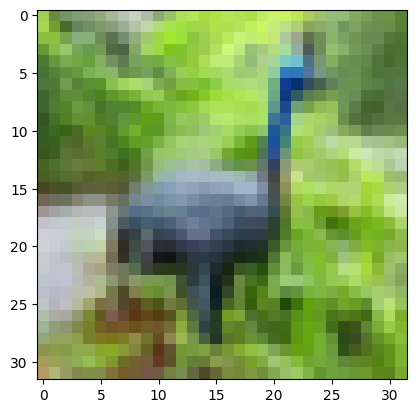

In [8]:
import matplotlib.pyplot as plt
plt.imshow(img.squeeze(0).permute(1,2,0))

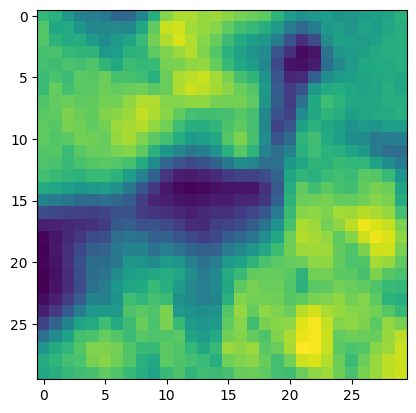

In [9]:
plt.imshow(output[0, 0].detach())
plt.show()

The fact that our output image is smaller than the input is a side effect of deciding what
to do at the boundary of the image. Applying a convolution kernel as a weighted sum
of pixels in a 3 × 3 neighborhood requires that there are neighbors in all directions. If
we are at i00, we only have pixels to the right of and below us. By default, PyTorch will
slide the convolution kernel within the input picture, getting width - kernel_width + 1
horizontal and vertical positions. For odd-sized kernels, this results in images that are one-half the convolution kernel’s width (in our case, 3//2 = 1) smaller on each side.
This explains why we’re missing two pixels in each dimension.

However, PyTorch gives us the possibility of padding the image by creating ghost pix-
els around the border that have value zero as far as the convolution is concerned. Fig-
ure 8.3 shows padding in action.
In our case, specifying padding=1 when kernel_size=3 means i00 has an extra set
of neighbors above it and to its left, so that an output of the convolution can be com-
puted even in the corner of our original image.3 The net result is that the output has
now the exact same size as the input:

In [10]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

![Figure_8.3.png](Images_ch8/Figure_8.3.png)


Let’s first zero out bias, just to remove any confounding factors, and then set
weights to a constant value so that each pixel in the output gets the mean of its neigh-
bors. For each 3 × 3 neighborhood:

In [11]:
# Averaging of pixels
import torch
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

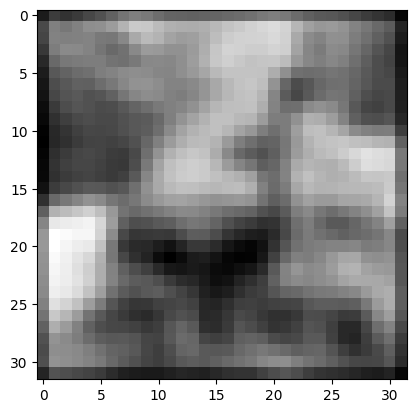

In [12]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [13]:
# Subtracting pixel on the left from pixels on the right
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
    [-1.0, 0.0, 1.0],
    [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

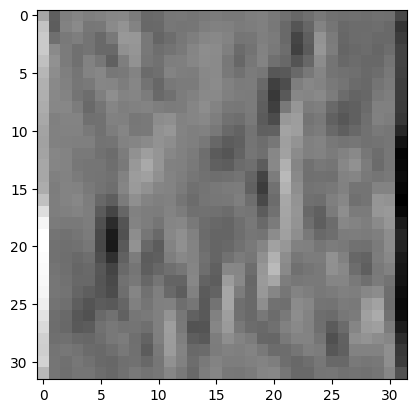

In [14]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

With deep learning, we let kernels be estimated from data in whatever way the dis-
crimination is most effective: for instance, in terms of minimizing the negative cross-
entropy loss between the output and the ground truth that we introduced in section
7.2.5. From this angle, the job of a convolutional neural network is to estimate the ker-
nel of a set of filter banks in successive layers that will transform a multichannel image
into another multichannel image, where different channels correspond to different
features (such as one channel for the average, another channel for vertical edges, and
so on). Figure 8.6 shows how the training automatically learns the kernels.

![Figure_8.6.png](Images_ch8/Figure_8.6.png)


Downsampling could in principle occur in different ways. Scaling an image by half is
the equivalent of taking four neighboring pixels as input and producing one pixel as
output. How we compute the value of the output based on the values of the input is
up to us. We could
* Average the four pixels. This average pooling was a common approach early on but
has fallen out of favor somewhat.
* Take the maximum of the four pixels. This approach, called max pooling, is currently
the most commonly used approach, but it has a downside of discarding the
other three-quarters of the data.
* Perform a strided convolution, where only every Nth pixel is calculated. A 3 × 4 convolu-
tion with stride 2 still incorporates input from all pixels from the previous layer.
The literature shows promise for this approach, but it has not yet supplanted
max pooling.

We will be focusing on max pooling, illustrated in figure 8.7, going forward. The fig-
ure shows the most common setup of taking non-overlapping 2 x 2 tiles and taking the
maximum over each of them as the new pixel at the reduced scale.
Intuitively, the output images from a convolution layer, especially since they are fol-
lowed by an activation just like any other linear layer, tend to have a high magnitude

![Figure_8.7.png](Images_ch8/Figure_8.7.png)


Max pooling is provided by the nn.MaxPool2d module (as with convolution, there are
versions for 1D and 3D data). It takes as input the size of the neighborhood over which
to operate the pooling operation. If we wish to downsample our image by half, we’ll want
to use a size of 2. Let’s verify that it works as expected directly on our input image:

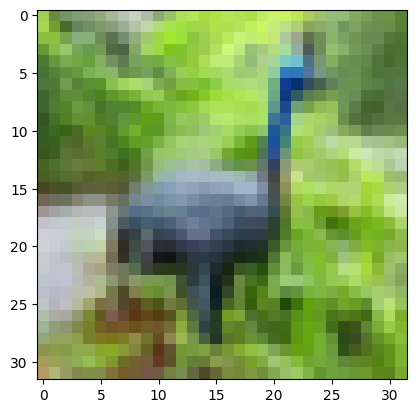

In [15]:
plt.imshow(img.permute(1,2,0))

In [16]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

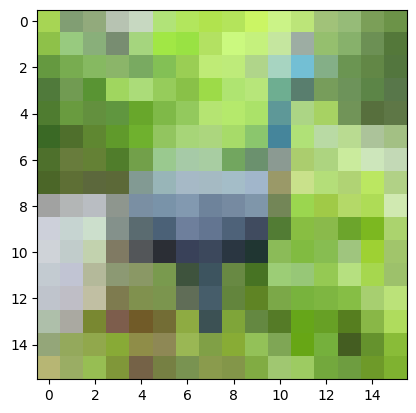

In [17]:
plt.imshow(output.squeeze(0).permute(1,2,0))

Let’s now see how combining convolutions and downsampling can help us recognize
larger structures. In figure 8.8, we start by applying a set of 3 × 3 kernels on our 8 × 8
image, obtaining a multichannel output image of the same size. Then we scale down
the output image by half, obtaining a 4 × 4 image, and apply another set of 3 × 3 ker-
nels to it. This second set of kernels operates on a 3 × 3 neighborhood of something
that has been scaled down by half, so it effectively maps back to 8 × 8 neighborhoods
of the input. In addition, the second set of kernels takes the output of the first set of
kernels (features like averages, edges, and so on) and extracts additional features on
top of those.

![Figure_8.8.png](Images_ch8/Figure_8.8.png)


With these building blocks in our hands, we can now proceed to build our convolu-
tional neural network for detecting birds and airplanes. Let’s take our previous fully
connected model as a starting point and introduce nn.Conv2d and nn.MaxPool2d as
described previously:

In [18]:
model = nn.Sequential(
nn.Conv2d(3, 16, kernel_size=3, padding=1),
nn.Tanh(),
nn.MaxPool2d(2),
nn.Conv2d(16, 8, kernel_size=3, padding=1),
nn.Tanh(),
nn.MaxPool2d(2),
# ...
)

The first convolution takes us from 3 RGB channels to 16, thereby giving the network
a chance to generate 16 independent features that operate to (hopefully) discrimi-
nate low-level features of birds and airplanes. Then we apply the Tanh activation func-
tion. The resulting 16-channel 32 × 32 image is pooled to a 16-channel 16 × 16 image
by the first MaxPool3d. At this point, the downsampled image undergoes another con-
volution that generates an 8-channel 16 × 16 output. With any luck, this output will
consist of higher-level features. Again, we apply a Tanh activation and then pool to an
8-channel 8 × 8 output.
Where does this end? After the input image has been reduced to a set of 8 × 8 fea-
tures, we expect to be able to output some probabilities from the network that we can
feed to our negative log likelihood. However, probabilities are a pair of numbers in a
1D vector (one for airplane, one for bird), but here we’re still dealing with multichan-
nel 2D features.

Thinking back to the beginning of this chapter, we already know what we need to
do: turn the 8-channel 8 × 8 image into a 1D vector and complete our network with a
set of fully connected layers:

In [19]:
model = nn.Sequential(
nn.Conv2d(3, 16, kernel_size=3, padding=1),
nn.Tanh(),
nn.MaxPool2d(2),
nn.Conv2d(16, 8, kernel_size=3, padding=1),
nn.Tanh(),
nn.MaxPool2d(2),
# Warning Something important is missing here
nn.Linear(8 * 8 * 8, 32),
nn.Tanh(),
nn.Linear(32, 2))

![Figure_8.9.png](Images_ch8/Figure_8.9.png)


Ignore the “something missing” comment for a minute. Let’s first notice that the size
of the linear layer is dependent on the expected size of the output of MaxPool2d: 8 × 8
× 8 = 512. Let’s count the number of parameters for this small model:

In [20]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

That’s very reasonable for a limited dataset of such small images. In order to increase
the capacity of the model, we could increase the number of output channels for the
convolution layers (that is, the number of features each convolution layer generates),
which would lead the linear layer to increase its size as well.
We put the “Warning” note in the code for a reason. The model has zero chance of
running without complaining:

In [21]:
try :
    model(img.unsqueeze(0))
except RuntimeError as error:
    print(error)

mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)


Admittedly, the error message is a bit obscure, but not too much so. We find refer-
ences to linear in the traceback: looking back at the model, we see that only module
that has to have a 512 × 32 tensor is nn.Linear(512, 32), the first linear module after
the last convolution block.
What’s missing there is the reshaping step from an 8-channel 8 × 8 image to a 512-
element, 1D vector (1D if we ignore the batch dimension, that is). This could be
achieved by calling view on the output of the last nn.MaxPool2d, but unfortunately, we
don’t have any explicit visibility of the output of each module when we use
nn.Sequential.4

## 8.3 Subclassing nn.Module

In order to subclass nn.Module, at a minimum we need to define a forward function
that takes the inputs to the module and returns the output. This is where we define our
module’s computation.

Typically, our computation will use other modules—premade like convolutions or
customized. To include these submodules, we typically define them in the constructor
__init__ and assign them to self for use in the forward function. They will, at the
same time, hold their parameters throughout the lifetime of our module. Note that you
need to call super().__init__() before you can do that (or PyTorch will remind you).

Let’s write our network as a submodule. To do so, we instantiate all the nn.Conv2d,
nn.Linear, and so on that we previously passed to nn.Sequential in the constructor,
and then use their instances one after another in forward:

In [22]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [23]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

What happens here is that the parameters() call delves into all submodules assigned
as attributes in the constructor and recursively calls parameters() on them. No mat-
ter how nested the submodule, any nn.Module can access the list of all child parame-
ters. By accessing their grad attribute, which has been populated by autograd, the
optimizer will know how to change parameters to minimize the loss.``

Looking back at the implementation of the Net class, and thinking about the
utility of registering submodules in the constructor so that we can access their param-
eters, it appears a bit of a waste that we are also registering submodules that have no
parameters, like nn.Tanh and nn.MaxPool2d. Wouldn’t it be easier to call these
directly in the forward function, just as we called view?

Back to our model, it makes sense to keep using nn modules for nn.Linear and
nn.Conv2d so that Net will be able to manage their Parameters during training. How-
ever, we can safely switch to the functional counterparts of pooling and activation,
since they have no parameters:

In [24]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

While general-purpose scientific functions like tanh still exist in
torch.nn.functional in version 1.0, those entry points are deprecated in
favor of functions in the top-level torch namespace. More niche functions
like max_pool2d will remain in torch.nn.functional.

In [25]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.0177, -0.1305]], grad_fn=<AddmmBackward0>)

We got two numbers! Information flows correctly. We might not realize it right now,
but in more complex models, getting the size of the first linear layer right is some-
times a source of frustration. We’ve heard stories of famous practitioners putting in
arbitrary numbers and then relying on error messages from PyTorch to backtrack the
correct sizes for their linear layers. Lame, eh? Nah, it’s all legit!

## 8.4 Training our convnet

Recall that the core of our convnet is two nested loops: an outer one over the
epochs and an inner one of the DataLoader that produces batches from our Dataset.
In each loop, we then have to

1. Feed the inputs through the model (the forward pass).
2. Compute the loss (also part of the forward pass).
3. Zero any old gradients.
4. Call loss.backward() to compute the gradients of the loss with respect to all parameters (the backward pass).
5. Have the optimizer take a step in toward lower loss.

In [26]:
# Uses the datetime module included with Python
import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1): # Our loop over the epochs, numbered from 1 to n_epochs rather than starting at 0
        loss_train = 0.0
        for imgs, labels in train_loader: # Loops over our dataset in the batches the data loader creates for us
            
            # Feeds a batch through our model …
            outputs = model(imgs)
            
            # and computes the loss we wish to minimize
            loss = loss_fn(outputs, labels)
            
            # After getting rid of the gradients from the last round …
            optimizer.zero_grad()
            
            # … performs the backward step. That is, we compute the gradients of all parameters we want the network to learn.
            loss.backward()
            
            # Updates the model
            optimizer.step()

            # Sums the losses we saw over the epoch. Recall that it is important to transform the loss to a Python number with .item(), to escape the gradients.
            loss_train += loss.item()

            # Divides by the length of the training data loader to get the average loss per batch. This is a much more intuitive measure than the sum. 
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

We use the Dataset from chapter 7; wrap it into a DataLoader; instantiate our net-
work, an optimizer, and a loss function as before; and call our training loop.
The substantial changes in our model from the last chapter are that now our
model is a custom subclass of nn.Module and that we’re using convolutions. Let’s run
training for 100 epochs while printing the loss. Depending on your hardware, this
may take 20 minutes or more to finish!

In [27]:
from torch import optim
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
shuffle=True)
model = Net() # Instantiates our network …
optimizer = optim.SGD(model.parameters(), lr=1e-2) #… the stochastic gradient descent optimizer we have been working with …
loss_fn = nn.CrossEntropyLoss() # … and the cross entropy loss we met in 7.10

# training_loop( # Calls the training loop we defined earlier
#     n_epochs = 100,
#     optimizer = optimizer,
#     model = model,
#     loss_fn = loss_fn,
#     train_loader = train_loader,
# )

In order to have a measure that is more interpretable than the loss, we can take a look
at our accuracies on the training and validation datasets. We use the same code as in
chapter 7:

In [28]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
shuffle=False)

In [29]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad(): #We do not want gradients here, as we will not want to update the parameters.
            for imgs, labels in loader:
                outputs = model(imgs)
                
                _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value as output
                
                total += labels.shape[0] # Counts the number of examples, so total is increased by the batch size
                
                correct += int((predicted == labels).sum()) #Comparing the predicted class that had the maximum probability and the 
                                                            # ground-truth labels, we first get a Boolean array. 
                                                            # Taking the sum gives the number of items in the batch where the prediction and ground truth agree.
        
        print("Accuracy {}: {:.2f}".format(name , correct / total))
validate(model, train_loader, val_loader)

Accuracy train: 0.52
Accuracy val: 0.53


In [30]:
# saving model
data_path = "Chapter 8 "
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

The birds_vs_airplanes.pt file now contains all the parameters of model: that is,
weights and biases for the two convolution modules and the two linear modules. So, no structure—just the weights. This means when we deploy the model in production
for our friend, we’ll need to keep the model class handy, create an instance, and then
load the parameters back into it:

In [31]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path
+ 'birds_vs_airplanes.pt'))

<All keys matched successfully>

But we also
need to move our parameters to the GPU. Happily, nn.Module implements a .to func-
tion that moves all of its parameters to the GPU (or casts the type when you pass a
dtype argument).


There is a somewhat subtle difference between Module.to and Tensor.to.
Module.to is in place: the module instance is modified. But Tensor.to is out of place
(in some ways computation, just like Tensor.tanh), returning a new tensor. One
implication is that it is good practice to create the Optimizer after moving the param-
eters to the appropriate device.
It is considered good style to move things to the GPU if one is available. A good
pattern is to set the a variable device depending on torch.cuda.is_available:

In [32]:
device = (torch.device('cuda') if torch.cuda.is_available()
else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


Then we can amend the training loop by moving the tensors we get from the data
loader to the GPU by using the Tensor.to method. Note that the code is exactly like
our first version at the beginning of this section except for the two lines moving the
inputs to the GPU:

In [33]:
import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            # These two lines that move imgs and labels to the device we are training on are 
            # the only difference from our previous version.
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))

The same amendment must be made to the validate function. We can then instanti-
ate our model, move it to device, and run it as before:8

In [34]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
shuffle=True)
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(
n_epochs = 100,
optimizer = optimizer,
model = model,
loss_fn = loss_fn,
train_loader = train_loader,
)

/home/adam/Coding/PyTorch Book/.venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


2024-08-09 21:12:01.993779 Epoch 1, Training loss 0.6812902225810251
2024-08-09 21:12:06.165249 Epoch 10, Training loss 0.4703231433014961
2024-08-09 21:12:10.374637 Epoch 20, Training loss 0.35901855857698783
2024-08-09 21:12:14.487933 Epoch 30, Training loss 0.3221468408206466
2024-08-09 21:12:18.872289 Epoch 40, Training loss 0.3055011162142845
2024-08-09 21:12:22.998709 Epoch 50, Training loss 0.28991608051167933
2024-08-09 21:12:26.841827 Epoch 60, Training loss 0.2742586063731248
2024-08-09 21:12:30.877726 Epoch 70, Training loss 0.2621721181140584
2024-08-09 21:12:34.812547 Epoch 80, Training loss 0.2514728094172326
2024-08-09 21:12:38.590161 Epoch 90, Training loss 0.2420360244288566
2024-08-09 21:12:42.621368 Epoch 100, Training loss 0.23041081708517802


Even for our small network here, we do see a sizable increase in speed. The advantage
of computing on GPUs is more visible for larger models.
There is a slight complication when loading network weights: PyTorch will attempt
to load the weight to the same device it was saved from—that is, weights on the GPU
will be restored to the GPU. As we don’t know whether we want the same device, we
have two options: we could move the network to the CPU before saving it, or move it
back after restoring. It is a bit more concise to instruct PyTorch to override the device
information when loading weights. This is done by passing the map_location keyword
argument to torch.load:

In [35]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
+ 'birds_vs_airplanes.pt',
map_location=device))

<All keys matched successfully>

## 8.5 Model design

Given our feed-forward architecture, there are a couple of dimensions we’d likely
want to explore before getting into further complications. The first dimension is the
width of the network: the number of neurons per layer, or channels per convolution.
We can make a model wider very easily in PyTorch. We just specify a larger number of
output channels in the first convolution and increase the subsequent layers accord-
ingly, taking care to change the forward function to reflect the fact that we’ll now
have a longer vector once we switch to fully connected layers:

In [36]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

If we want to avoid hardcoding numbers in the definition of the model, we can easily
pass a parameter to init and parameterize the width, taking care to also parameterize
the call to view in the forward function:

In [37]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2) 
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

The numbers specifying channels and features for each layer are directly related to
the number of parameters in a model; all other things being equal, they increase the
capacity of the model. As we did previously, we can look at how many parameters our
model has now

In [39]:
model = NetWidth()
sum(p.numel() for p in model.parameters())

38386

There are a few more tricks we can play at the model level (without acting on the
data) to control overfitting. Let’s review the most common ones.

Training a model involves two critical steps: optimization, when we need the loss to
decrease on the training set; and generalization, when the model has to work not only
on the training set but also on data it has not seen before, like the validation set. The
mathematical tools aimed at easing these two steps are sometimes subsumed under
the label regularization.

The first way to stabilize generalization is to add a regularization term to the loss. This
term is crafted so that the weights of the model tend to be small on their own, limiting
how much training makes them grow. In other words, it is a penalty on larger weight
values. This makes the loss have a smoother topography, and there’s relatively less to
gain from fitting individual samples.

L2 regularization is also referred to as weight decay

In PyTorch, we could implement regularization pretty easily by adding a term to
the loss. After computing the loss, whatever the loss function is, we can iterate the
parameters of the model, sum their respective square (for L2) or abs (for L1), and
backpropagate:

In [44]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
            for p in model.parameters())
            
            print(l2_lambda * l2_norm)
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))

However, the SGD optimizer in PyTorch already has a weight_decay parameter that
corresponds to 2 * lambda, and it directly performs weight decay during the update
as described previously. It is fully equivalent to adding the L2 norm of weights to the
loss, without the need for accumulating terms in the loss and involving autograd.

The idea behind dropout is indeed simple: zero out a random fraction of out-
puts from neurons across the network, where the randomization happens at each
training iteration.

This procedure effectively generates slightly different models with different neu-
ron topologies at each iteration, giving neurons in the model less chance to coordi-
nate in the memorization process that happens during overfitting. An alternative
point of view is that dropout perturbs the features being generated by the model,
exerting an effect that is close to augmentation, but this time throughout the network.

In PyTorch, we can implement dropout in a model by adding an nn.Dropout mod-
ule between the nonlinear activation function and the linear or convolutional module
of the subsequent layer. As an argument, we need to specify the probability with which
inputs will be zeroed out. In case of convolutions, we’ll use the specialized nn.Drop-
out2d or nn.Dropout3d, which zero out entire channels of the input:

In [45]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Dropout was all the rage when, in 2015, another seminal paper was published by
Sergey Ioffe and Christian Szegedy from Google, entitled “Batch Normalization:
Accelerating Deep Network Training by Reducing Internal Covariate Shift”
(https://arxiv.org/abs/1502.03167). The paper described a technique that had mul-
tiple beneficial effects on training: allowing us to increase the learning rate and make
training less dependent on initialization and act as a regularizer, thus representing an
alternative to dropout.

The main idea behind batch normalization is to rescale the inputs to the activa-
tions of the network so that minibatches have a certain desirable distribution. Recall-
ing the mechanics of learning and the role of nonlinear activation functions, this
helps avoid the inputs to activation functions being too far into the saturated portion
of the function, thereby killing gradients and slowing training.

In [46]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

As minibatches are processed, in addition to estimating the mean and standard
deviation for the current minibatch, PyTorch also updates the running estimates for
mean and standard deviation that are representative of the whole dataset, as an
approximation. This way, when the user specifies

In [47]:
model.eval()

NetWidth(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

A skip connection is nothing but
the addition of the input to the output
of a block of layers. This is exactly how
it is done in PyTorch. Let’s add one
layer to our simple convolutional
model, and let’s use ReLU as the acti-
vation for a change. The vanilla mod-
ule with an extra layer looks like this:

![Figure_8.11.png](Images_ch8/Figure_8.11.png)


In [50]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
        kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

Adding a skip connection a la ResNet to this model amounts to adding the output of
the first layer in the forward function to the input of the third layer:

In [51]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
        kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

We talked about exceeding 100 layers in a convolutional neural network. How can we
build that network in PyTorch without losing our minds in the process? The standard
strategy is to define a building block, such as a (Conv2d, ReLU, Conv2d) + skip
connection block, and then build the network dynamically in a for loop. Let’s see it
done in practice. We will create the network depicted in figure 8.12.

![Figure_8.12.png](Images_ch8/Figure_8.12.png)


We first create a module subclass whose sole job is to provide the computation for one
block—that is, one group of convolutions, activation, and skip connection:

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
        padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
        nonlinearity='relu') # Uses custom initializations . kaiming_normal_ initializes with normal random elements 
        # with standard deviation as computed in 
        # the ResNet paper. The batch norm is initialized to produce output distributions that initially have 0 mean and 0.5 variance.
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

First, in init, we create nn.Sequential containing a list of ResBlock instances.
nn.Sequential will ensure that the output of one block is used as input to the next. It
will also ensure that all the parameters in the block are visible to Net. Then, in forward,
we just call the sequential to traverse the 100 blocks and generate the output:

In [53]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
        *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

We summarize the effect of each of our design modifications in isolation in figure
8.13. We should not overinterpret any of the specific numbers—our problem setup
and experiments are simplistic, and repeating the experiment with different random
seeds will probably generate variation at least as large as the differences in validation
accuracy. For this demonstration, we left all other things equal, from learning rate to
number of epochs to train; in practice, we would try to get the best results by varying
those. Also, we would likely want to combine some of the additional design elements.

![Figure_8.13.png](Images_ch8/Figure_8.13.png)


## Summary

* Convolution can be used as the linear operation of a feed-forward network
dealing with images. Using convolution produces networks with fewer parame-
ters, exploiting locality and featuring translation invariance.
* Stacking multiple convolutions with their activations one after the other, and
using max pooling in between, has the effect of applying convolutions to
increasingly smaller feature images, thereby effectively accounting for spatial
relationships across larger portions of the input image as depth increases.
* Any nn.Module subclass can recursively collect and return its and its children’s
parameters. This technique can be used to count them, feed them into the opti-
mizer, or inspect their values.
* The functional API provides modules that do not depend on storing internal
state. It is used for operations that do not hold parameters and, hence, are not
trained.
* Once trained, parameters of a model can be saved to disk and loaded back in
with one line of code each.